<a href="https://colab.research.google.com/github/ZinaTlish/DZ-DA/blob/main/%D0%94%D0%975%D0%90%D0%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

In [15]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
def load_data(file_path):
    return pd.read_csv(file_path, sep=',')

In [6]:
def load_tweets(file_path, columns):
    tweet = pd.read_excel(file_path)
    tweet = tweet.iloc[:, :columns]
    tweet['date'] = pd.to_datetime(tweet['date'], errors='coerce')
    tweet = tweet[pd.to_numeric(tweet['retweets'], errors='coerce').notnull()]
    tweet['retweets'] = pd.to_numeric(tweet['retweets'])
    return tweet

In [7]:
def plot_retweets_over_time(tweet):
    plt.figure(figsize=(10, 6))
    plt.plot(tweet['date'], tweet['retweets'], marker='o', linestyle='-', color='b')
    plt.title('Retweets Over Time')
    plt.xlabel('Date')
    plt.ylabel('Retweets')
    plt.tight_layout()
    plt.show()


In [8]:
def process_vaccination_data(vac):
    return (vac.groupby('date')
            .agg({'location': 'count', 'daily_vaccinations': 'sum'})
            .reset_index()
            .rename(columns={'location': 'counties_count'}))


In [9]:
def plot_vaccination_over_time(vac):
    plt.plot(vac['date'], vac["daily_vaccinations"])

In [10]:
def AR_model(data_v, order, amount):
    kfs = np.ones(order)
    X_mat = np.array([data_v[i:order + i] for i in range(len(data_v) - order - 1)])
    kfs = np.linalg.lstsq(X_mat, data_v[order + 1:len(data_v)])[0]

    vect = data_v.values
    for i in range(amount):
        pred = kfs @ vect[-order:]
        vect = np.append(vect, pred)

    kmat = np.zeros((len(kfs), len(kfs)))
    for i in range(len(kfs)):
        kmat[i, i] = kfs[i]

    return vect

In [11]:
def combined_AR(X, Y, order_x, order_y, amount):
    kfs = np.ones(order_x + order_y)
    X_lagged = np.array([X[i:order_x + i] for i in range(len(X) - order_x - 1)])
    Y_lagged = np.array([Y[i:order_y + i] for i in range(len(Y) - order_y - 1)])
    XY_matrix = np.column_stack((X_lagged, Y_lagged))

    try:
        kfs = np.linalg.lstsq(XY_matrix, X[order_x + 1:len(X)])[0]
    except np.linalg.LinAlgError:
        print("Matrix is singular. Granger causality test may not be applicable.")
        return None

    vect_X = X.values
    vect_Y = Y.values

    for i in range(amount):
        pred = kfs @ np.concatenate((vect_X[-order_x:], vect_Y[-order_y:]))
        vect_X = np.append(vect_X, pred)
        vect_Y = np.append(vect_Y, 0)

    min_length = min(len(vect_X), len(vect_Y))
    vect_X = vect_X[:min_length]
    vect_Y = vect_Y[:min_length]

    return vect_X

In [12]:
def calculate_f_statistic(y_with_lag, y_without_lag, p, q, n):
    mse_with_lag = np.mean(y_with_lag ** 2)
    mse_without_lag = np.mean(y_without_lag ** 2)
    f_statistic = ((mse_without_lag - mse_with_lag) / p) / (mse_with_lag / (n - p - q))
    p_value = f.sf(f_statistic, p, n - p - q)
    return f_statistic, p_value

In [23]:
def granger_causality_test(X, Y, max_lag):
    min_length = min(len(X), len(Y))
    X = X[:min_length]
    Y = Y[:min_length]

    data = np.column_stack((X, Y))
    test_result = grangercausalitytests(data, max_lag, verbose=True)

    for lag in range(1, max_lag + 1):
        print(f"Results for lag {lag}:")
        p_value = test_result[lag][0]['ssr_ftest'][1]
        is_causal = p_value < 0.05
        print(f"P-value: {p_value}, Is causal: {is_causal}")


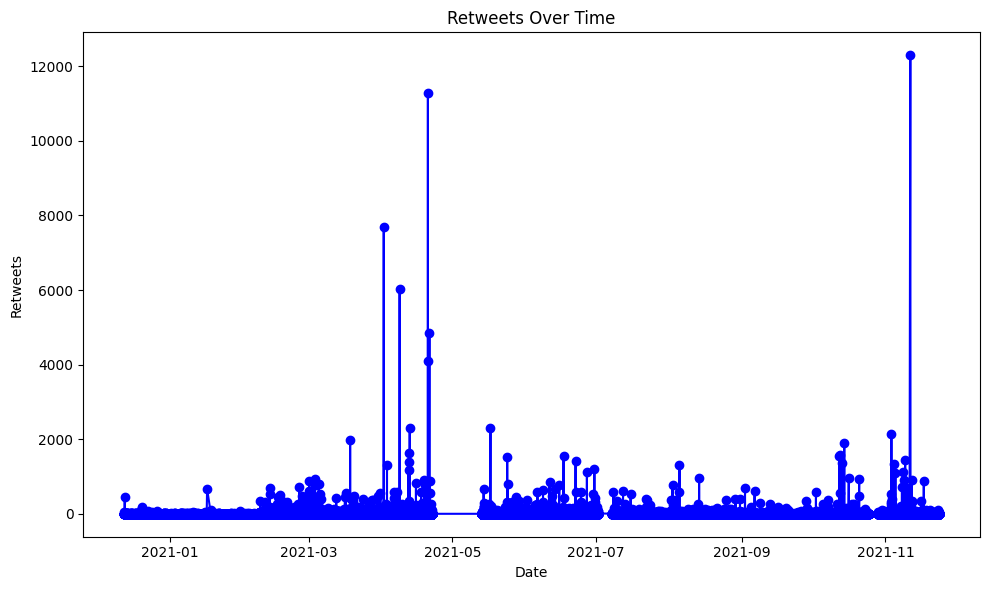

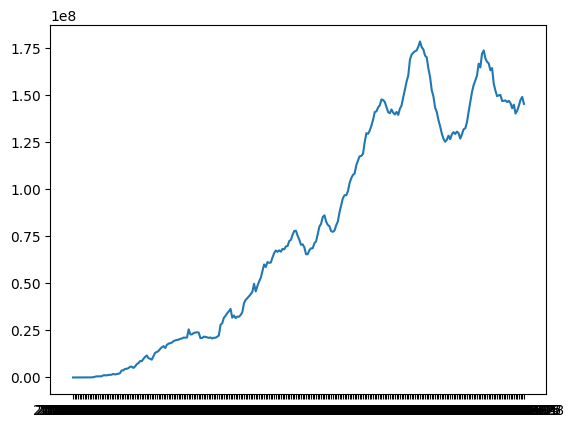

In [16]:
PREDICT_RANGE = 25
vac = load_data('/content/gdrive/MyDrive/Covid/vac.csv')
tweet = load_tweets('/content/gdrive/MyDrive/Covid/tweetss.xlsx', 16)
plot_retweets_over_time(tweet)

vac = process_vaccination_data(vac)
plot_vaccination_over_time(vac)

daily_vac = vac["daily_vaccinations"]
daily_tweet = tweet["retweets"]

In [17]:
predict_range = PREDICT_RANGE
lag = len(daily_vac) - predict_range - 2
pred = AR_model(daily_vac[:int(len(daily_vac)) - predict_range], lag, predict_range)


<ipython-input-10-d0a629b13222>:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  kfs = np.linalg.lstsq(X_mat, data_v[order + 1:len(data_v)])[0]


In [18]:
pred_lag = combined_AR(daily_vac[:int(len(daily_vac)) - predict_range],
                        daily_tweet[:int(len(daily_vac)) - predict_range],
                        lag, lag, predict_range)


<ipython-input-11-37ba277709d5>:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  kfs = np.linalg.lstsq(XY_matrix, X[order_x + 1:len(X)])[0]


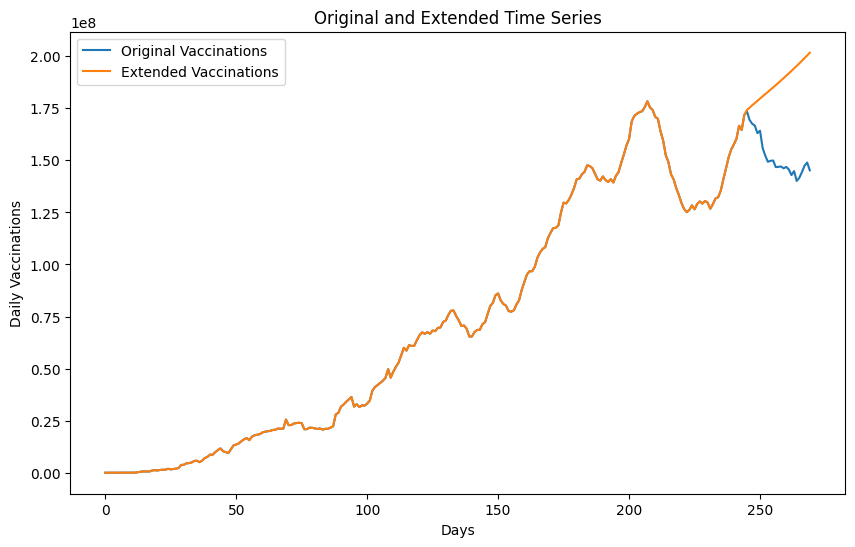

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(daily_vac, label='Original Vaccinations')
plt.plot(pred_lag, label='Extended Vaccinations')
plt.xlabel('Days')
plt.ylabel('Daily Vaccinations')
plt.legend()
plt.title('Original and Extended Time Series')
plt.show()


In [24]:
granger_causality_test(daily_vac, daily_tweet, PREDICT_RANGE)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0113  , p=0.9154  , df_denom=266, df_num=1
ssr based chi2 test:   chi2=0.0114  , p=0.9148  , df=1
likelihood ratio test: chi2=0.0114  , p=0.9148  , df=1
parameter F test:         F=0.0113  , p=0.9154  , df_denom=266, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0117  , p=0.9884  , df_denom=263, df_num=2
ssr based chi2 test:   chi2=0.0238  , p=0.9882  , df=2
likelihood ratio test: chi2=0.0238  , p=0.9882  , df=2
parameter F test:         F=0.0117  , p=0.9884  , df_denom=263, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0110  , p=0.9984  , df_denom=260, df_num=3
ssr based chi2 test:   chi2=0.0338  , p=0.9984  , df=3
likelihood ratio test: chi2=0.0338  , p=0.9984  , df=3
parameter F test:         F=0.0110  , p=0.9984  , df_denom=260, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4636  , p=0.7624  

Количество вакцинаций по тесту Грейнджера не связано с количеством твитов о них.